In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

**Tải stopwords**

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = pd.read_csv('/content/Reviews.csv')
df = df[['Text', 'Score']].dropna()

**Tiền xử lý dữ liệu, làm sạch văn bản**

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)  #xóa ký tự không phải chữ cái
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

df['Text'] = df['Text'].apply(clean_text)

**Chuyển đổi điểm thành nhãn**

In [ ]:
def convert_score(score):
    if score <= 2:
        return 0  # negative
    elif score == 3:
        return 1  # neutral
    else:
        return 2  # positive

df['label'] = df['Score'].apply(convert_score)

**Chia dữ liệu: 80% train_val, 20% test.
Từ train_val: 80% train, 20% validation**

In [ ]:
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, stratify=train_val_df['label'], random_state=42)

**Chuẩn bị dữ liệu**

In [ ]:
X_train = train_df['Text'].values
y_train = train_df['label'].values
X_val = val_df['Text'].values
y_val = val_df['label'].values
X_test = test_df['Text'].values
y_test = test_df['label'].values

In [ ]:
print("Train:", train_df['label'].value_counts())
print("Validation:", val_df['label'].value_counts())
print("Test:", test_df['label'].value_counts())

Train: label
2    284016
0     52504
1     27290
Name: count, dtype: int64
Validation: label
2    71005
0    13126
1     6822
Name: count, dtype: int64
Test: label
2    88756
0    16407
1     8528
Name: count, dtype: int64


In [ ]:
train_df.head()

,Text,Score,label
453228,coffee tastes expresso based strong bitter fav...,5,2
333958,mother eaten cereal since teens lot difficulty...,5,2
528461,one hour homemade soup prep needed seasoning p...,4,2
204251,researched medium priced good quality foods ma...,5,2
38265,hey great breakfast combo along juice milk tea...,5,2


In [ ]:
val_df.head()

,Text,Score,label
546341,great elderberry jelly fast delivery got husba...,5,2
519860,best tasting chips addicting great taste healt...,5,2
236923,truly love tea living far city far arabic stor...,5,2
235392,successful losing weight really miss cookies t...,5,2
275534,marley coffee beautiful strong aroma brewing l...,4,2


In [ ]:
test_df.head()

,Text,Score,label
277691,enjoy popchip flavours one nice balance get ti...,4,2
433287,really like donut shop coffe tried one nearly ...,3,1
239489,good flavor good texture definately splurge ki...,4,2
265440,numi tea sampler lot offer enjoy mild teas pre...,4,2
7979,starbucks proven world best coffee company new...,5,2


**Thiết lập tham số**

In [ ]:
vocab_size = 20000
max_len = 200
embedding_dim = 100

**Tokenization và padding**

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

**Tính class weight để xử lý mất cân bằng lớp**

In [ ]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

**Xây dựng mô hình**

In [ ]:
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len, trainable=True),  # Embedding tự huấn luyện
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 3 lớp: negative, neutral, positive
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


**Biên dịch mô hình**

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 200, 256)       │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,811 (9.25 MB)

 Trainable params: 2,423,811 (9.25 MB)

 Non-trainable params: 0 (0.00 B)

**Thiết lập early stopping**

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

**Huấn luyện mô hình**

In [ ]:
history = model.fit(X_train_pad, y_train,
                    validation_data=(X_val_pad, y_val),
                    epochs=10,
                    batch_size=128,
                    callbacks=[early_stopping],
                    class_weight=class_weights_dict)

Epoch 1/10
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 180s 62ms/step - accuracy: 0.6955 - loss: 0.8228 - val_accuracy: 0.7551 - val_loss: 0.6063
Epoch 2/10
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 207s 64ms/step - accuracy: 0.8050 - loss: 0.5829 - val_accuracy: 0.8131 - val_loss: 0.4852
Epoch 3/10
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 196s 61ms/step - accuracy: 0.8403 - loss: 0.4761 - val_accuracy: 0.8213 - val_loss: 0.4664
Epoch 4/10
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 181s 64ms/step - accuracy: 0.8651 - loss: 0.3932 - val_accuracy: 0.8304 - val_loss: 0.4487
Epoch 5/10
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 196s 62ms/step - accuracy: 0.8879 - loss: 0.3221 - val_accuracy: 0.8403 - val_loss: 0.4909
Epoch 6/10
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 181s 63ms/step - accuracy: 0.9061 - loss: 0.2634 - val_accuracy: 0.8310 - val_loss: 0.4674
Epoch 7/10
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 202s 64ms/step - accuracy: 0.9174 - loss: 0.2210 - val_accuracy: 0.8583 - val_loss: 0.4873


**Dự đoán trên tập test**

In [ ]:
y_pred = model.predict(X_test_pad)
y_pred_classes = y_pred.argmax(axis=1)

3553/3553 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step


**Báo cáo phân loại**

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['negative', 'neutral', 'positive']))

Classification Report:
              precision    recall  f1-score   support

    negative       0.73      0.78      0.75     16407
     neutral       0.33      0.69      0.44      8528
    positive       0.97      0.85      0.91     88756

    accuracy                           0.83    113691
   macro avg       0.68      0.77      0.70    113691
weighted avg       0.89      0.83      0.85    113691



**Ma trận nhầm lẫn**

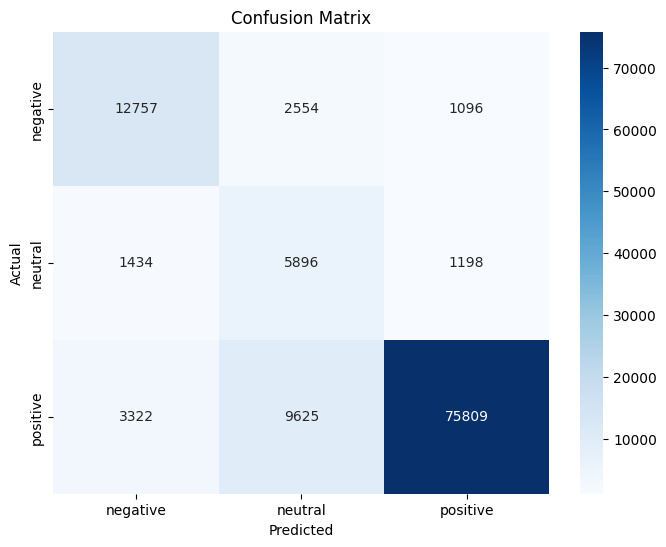

In [ ]:
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

**Vẽ biểu đồ loss và accuracy**

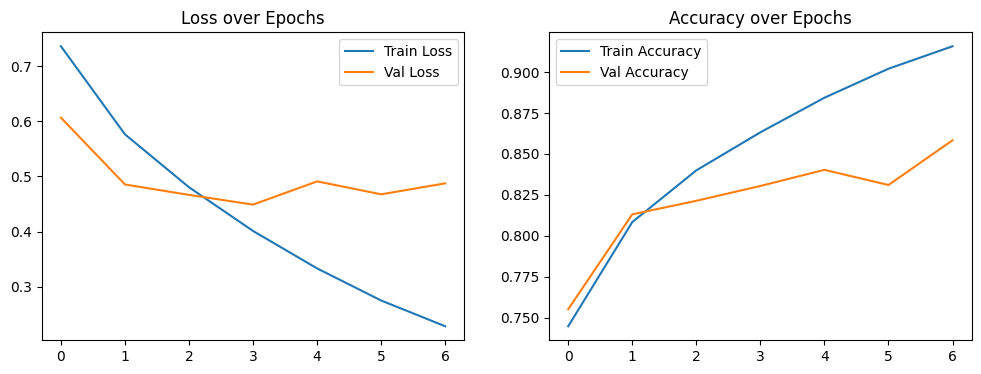

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()

**Lưu mo hình và tokenizer**

In [ ]:
model.save('sentiment_model.h5')
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Model and tokenizer have been saved.")

Model and tokenizer have been saved.


**Dự đoán cảm xúc cho 1 câu**

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def predict_sentiment(sentence, tokenizer, model, max_len=200):
    sentence_cleaned = clean_text(sentence)
    sequence = tokenizer.texts_to_sequences([sentence_cleaned])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post')
    prediction = model.predict(padded)
    label = np.argmax(prediction)

    label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    return label_map[label], prediction


In [ ]:
sentence = "The food was absolutely wonderful and the service was excellent!"
label, confidence = predict_sentiment(sentence, tokenizer, model)
print("Sentiment:", label)
print("Confidence:", confidence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Sentiment: Positive
Confidence: [[0.0024343  0.01076291 0.98680276]]


In [ ]:
sentence = "The food today is terrible."
label, confidence = predict_sentiment(sentence, tokenizer, model)
print("Sentiment:", label)
print("Confidence:", confidence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Sentiment: Negative
Confidence: [[0.98087466 0.01058553 0.0085398 ]]


In [ ]:
sentence = "This dish was okay, but not great."
label, confidence = predict_sentiment(sentence, tokenizer, model)
print("Sentiment:", label)
print("Confidence:", confidence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Sentiment: Neutral
Confidence: [[0.04091679 0.93796253 0.02112062]]


In [ ]:
sentence = "I really like the fried chicken here."
label, confidence = predict_sentiment(sentence, tokenizer, model)
print("Sentiment:", label)
print("Confidence:", confidence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Sentiment: Positive
Confidence: [[0.01112344 0.04951268 0.9393639 ]]


In [ ]:
sentence = "Lan Anh said that she hates eating lemons."
label, confidence = predict_sentiment(sentence, tokenizer, model)
print("Sentiment:", label)
print("Confidence:", confidence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Sentiment: Negative
Confidence: [[0.9213506  0.03852564 0.04012376]]
